Predicting 

In [79]:
def prepare_img(img_path, target_size=(256, 256)):
    from tensorflow.keras.preprocessing import image
    import numpy as np
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [80]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_class_with_confidence(model, img_path, threshold=0.5):
    """
    Prédit si une image est de la classe 'Perlites' ou 'Martensites' en utilisant un modèle donné,
    et fournit le pourcentage de confiance de cette prédiction.
    
    Args:
    - model: Le modèle entraîné pour la prédiction.
    - img_path (str): Le chemin vers l'image à prédire.
    - threshold (float): Le seuil pour décider de la classe.
    
    Returns:
    - tuple: La prédiction de la classe ('Perlites' ou 'Martensites') et le pourcentage de confiance.
    """
    # Chargement et prétraitement de l'image
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Convertit l'image en un batch de taille 1
        
    # Faire la prédiction
    prediction = model.predict(img_array)
    confidence = prediction[0][0]  # Obtient la confiance de la prédiction
    
    # Interpréter la prédiction
    predicted_class = 'Perlites' if confidence >= threshold else 'Martensites'
    confidence_percentage = confidence * 100 if predicted_class == 'Perlites' else (1 - confidence) * 100
    
    return predicted_class, confidence_percentage

In [ ]:
# Exemple d'utilisation
img_path = '/home/riccardo/Documents/AI_work_3/Prt_03.2024/Grain-segmentation_prjt/Dataset/ImageDataGen_825_cleaned/test/Martensite_microstructure_img_cropped_V3_manualy_cleaned_yolo/download (25)_cropped_0.png'
predicted_class, confidence = predict_class_with_confidence(model, img_path, threshold=0.5)
print(f"Classe prédite : {predicted_class} avec {confidence:.2f}% de confiance")

Prediction on test-set

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import itertools
import matplotlib.pyplot as plt

2024-03-21 13:33:19.174961: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-21 13:33:19.216209: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-21 13:33:19.216732: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 13:33:20.045316: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
def preprocess_image_grayscale(img):
    """Convertit une image RGB en niveaux de gris et la duplique sur 3 canaux."""
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.grayscale_to_rgb(img)
    return img

In [3]:
# Chemin vers votre dossier de test
test_dir = '/home/riccardo/Documents/AI_work_3/Prt_03.2024/Grain-segmentation_prjt/Dataset/ImageDataGen_825_cleaned/test'

# Paramètres
batch_size = 32
target_size = (256, 256)

# Préparation des données de test
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image_grayscale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)  # Important pour garder les étiquettes dans le bon ordre

Found 52 images belonging to 2 classes.


In [4]:
# Chargement du modèle
model = tf.keras.models.load_model('/home/riccardo/Documents/AI_work_3/Prt_03.2024/Grain-segmentation_prjt/Models/Main_classification_model/Class_pearl_mart_cleaned_V7_batch32_grey_865_without_lowconf.h5')

In [7]:
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size), verbose=1)
predicted_classes = np.where(predictions > 0.5, 1, 0).reshape(-1)  # Seuil de 0.5 pour classification binaire

# Vrais labels
true_classes = test_generator.classes

# Noms des fichiers dans l'ensemble de test
filenames = test_generator.filenames

# Erreurs de prédiction
errors = np.where(predicted_classes != true_classes)[0]

# Noms des fichiers mal prédits
error_files = [filenames[i] for i in errors]

accuracy = accuracy_score(true_classes, predicted_classes)
conf_matrix = confusion_matrix(true_classes, predicted_classes)
class_report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices)

print("Accuracy sur l'ensemble de test:", accuracy_score(true_classes, predicted_classes))
print("Matrice de confusion :")
print(conf_matrix)
print("Rapport de classification :")
print(classification_report(true_classes, predicted_classes, target_names=list(test_generator.class_indices)))

# Afficher les fichiers mal prédits
# print("Images mal prédites :")
# for error_file in error_files:
#     print(error_file)

# Écrire les fichiers mal prédits dans un fichier texte
with open('images_mal_predites.txt', 'w') as f:
    for error_file in error_files:
        f.write(error_file + '\n')

print(f"Les images mal prédites ont été enregistrées dans le fichier 'images_mal_predites.txt'.")

2/2 [==============================] - 3s 395ms/step
Accuracy sur l'ensemble de test: 0.8461538461538461
Matrice de confusion :
[[17  3]
 [ 5 27]]
Rapport de classification :
                                                               precision    recall  f1-score   support

Martensite_microstructure_img_cropped_V3_manualy_cleaned_yolo       0.77      0.85      0.81        20
          pearlite_microstructure_img_cropped_V3_cleaned_yolo       0.90      0.84      0.87        32

                                                     accuracy                           0.85        52
                                                    macro avg       0.84      0.85      0.84        52
                                                 weighted avg       0.85      0.85      0.85        52

Les images mal prédites ont été enregistrées dans le fichier 'images_mal_predites.txt'.


Matrice de confusion PLOT 

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matrice de confusion',
                          cmap=plt.cm.Blues):
    """
    Cette fonction affiche la matrice de confusion.
    La normalisation peut être appliquée en réglant `normalize=True`.
    Les étiquettes des classes sont tronquées à 15 caractères pour améliorer la lisibilité.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Tronquer les noms de classes à 15 caractères
    truncated_classes = [cls[:15] + '...' if len(cls) > 15 else cls for cls in classes]
    tick_marks = np.arange(len(truncated_classes))

    plt.xticks(tick_marks, truncated_classes, rotation=45, ha='right')
    plt.yticks(tick_marks, truncated_classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') if normalize else int(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Vrai label')
    plt.xlabel('Label prédit')
    plt.tight_layout()
    plt.show()


<Figure size 640x480 with 0 Axes>

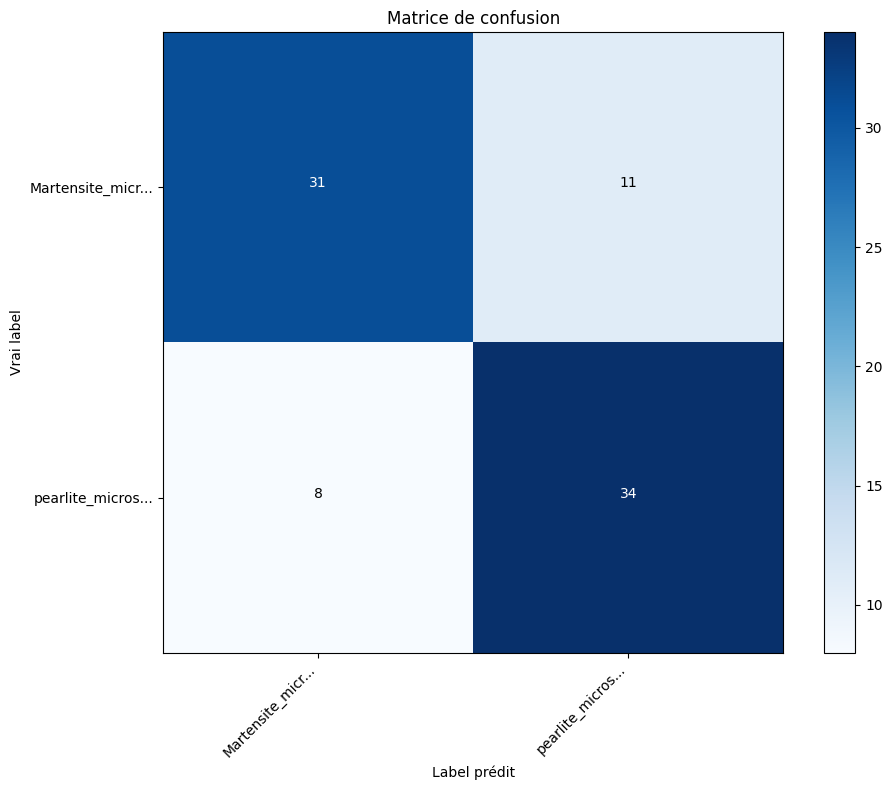

In [ ]:
# Afficher la matrice de confusion
plt.figure()
plot_confusion_matrix(conf_matrix, classes=list(test_generator.class_indices.keys()), title='Matrice de confusion')
plt.show()

Pytorch prediction on test set

In [64]:
from ultralytics import YOLO

on passe ImageDataGenerator en premier pour garder le même ordres 

In [65]:
def preprocess_image_grayscale(img):
    """Convertit une image RGB en niveaux de gris et la duplique sur 3 canaux."""
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.grayscale_to_rgb(img)
    return img


# Chemin vers votre dossier de test
test_dir = '/home/riccardo/Documents/AI_work_3/Prt_03.2024/Grain-segmentation_prjt/Dataset/ImageDataGen_825_cleaned/test'

# Paramètres
batch_size = 32
target_size = (224, 224)

# Préparation des données de test
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image_grayscale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)  # Important pour garder les étiquettes dans le bon ordre

Found 52 images belonging to 2 classes.


on extrait l'ordre de imagedatagenerator

In [66]:
import os
# Après avoir créé `test_generator` avec `flow_from_directory`
image_paths = test_generator.filenames

# Liste pour stocker tous les chemins d'images trouvés
list_img_path = []

# Afficher les chemins complets
full_paths = [os.path.join(test_dir, path) for path in image_paths]
for path in full_paths:
    # print(path)
    list_img_path.append(path)

In [67]:
# Load a model
model = YOLO('/home/riccardo/Documents/AI_work_3/Prt_03.2024/Grain-segmentation_prjt/Models/Main_classification_model/yolo_class_training_865img/best.pt')  # pretrained YOLOv8n model

# OR define a recursive glob search for all JPG files including subdirectories
# source = '/home/riccardo/Visual_Studio_Code/Grain-segmentation_prjt/Dataset_Structures_modes/ImageDataGen_825_cleaned/test/**/*.png'

In [73]:
results = model(list_img_path)


0: 224x224 Martensite_microstructure_img_cropped_V3_manualy_cleaned_yolo 1.00, pearlite_microstructure_img_cropped_V3_cleaned_yolo 0.00, 1: 224x224 Martensite_microstructure_img_cropped_V3_manualy_cleaned_yolo 1.00, pearlite_microstructure_img_cropped_V3_cleaned_yolo 0.00, 2: 224x224 Martensite_microstructure_img_cropped_V3_manualy_cleaned_yolo 1.00, pearlite_microstructure_img_cropped_V3_cleaned_yolo 0.00, 3: 224x224 Martensite_microstructure_img_cropped_V3_manualy_cleaned_yolo 0.97, pearlite_microstructure_img_cropped_V3_cleaned_yolo 0.03, 4: 224x224 Martensite_microstructure_img_cropped_V3_manualy_cleaned_yolo 1.00, pearlite_microstructure_img_cropped_V3_cleaned_yolo 0.00, 5: 224x224 Martensite_microstructure_img_cropped_V3_manualy_cleaned_yolo 0.98, pearlite_microstructure_img_cropped_V3_cleaned_yolo 0.02, 6: 224x224 Martensite_microstructure_img_cropped_V3_manualy_cleaned_yolo 1.00, pearlite_microstructure_img_cropped_V3_cleaned_yolo 0.00, 7: 224x224 Martensite_microstructure_img

In [74]:
# Utiliser la méthode top1 pour obtenir directement les labels prédits
predicted_classes = [result.probs.top1 for result in results]

Extraire l'ordre que ImageDataGenerator genere 

In [70]:
# Extraire les étiquettes réelles à partir du test_generator
true_classes = test_generator.classes

In [78]:
# true_classes

In [76]:
from sklearn.metrics import confusion_matrix


# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(true_classes, predicted_classes)

print("Matrice de confusion :")
print(conf_matrix)

Matrice de confusion :
[[20  0]
 [ 0 32]]


In [77]:
from sklearn.metrics import accuracy_score

# Calcul de l'accuracy
accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 100.00%


construiction d'un csv qui contient tou les chemin 

In [ ]:
import glob
import csv

# Définir le chemin source avec le motif de recherche
source = '/home/riccardo/Documents/AI_work_3/Prt_03.2024/Grain-segmentation_prjt/Dataset/ImageDataGen_825_cleaned/test/**/*.png'

# Utiliser glob pour trouver tous les fichiers qui correspondent au motif
image_paths = glob.glob(source, recursive=True)

# Nom du fichier CSV de sortie
csv_file = 'image_paths.csv'

# Écrire les chemins dans le fichier CSV
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image Path'])  # En-tête de colonne
    for path in image_paths:
        writer.writerow([path])

print(f"{len(image_paths)} image paths have been written to {csv_file}")


52 image paths have been written to image_paths.csv


On crée une liste de chemins 

In [ ]:
import csv
import glob

# Chemins de recherche pour les images dans les deux dossiers
patterns = [
    '/home/riccardo/Documents/AI_work_3/Prt_03.2024/Grain-segmentation_prjt/Dataset/ImageDataGen_825_cleaned/test/pearlite_microstructure_img_cropped_V3_cleaned_yolo/*.png',
    '/home/riccardo/Documents/AI_work_3/Prt_03.2024/Grain-segmentation_prjt/Dataset/ImageDataGen_825_cleaned/test/Martensite_microstructure_img_cropped_V3_manualy_cleaned_yolo/*.png'
]

# Liste pour stocker tous les chemins d'images trouvés
image_paths = []

# Chercher des images et les ajouter à la liste
for pattern in patterns:
    image_paths.extend(glob.glob(pattern))

# Chemin du fichier CSV à générer
csv_file_path = '/home/riccardo/Documents/AI_work_3/Prt_03.2024/Grain-segmentation_prjt/image_paths.csv'

# Écrire les chemins dans un fichier CSV
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Image Path'])  # Écrire l'en-tête
    for path in image_paths:
        writer.writerow([path])  # Écrire chaque chemin d'image

print(f"Nombre de chemins d'images écrits dans le CSV : {len(image_paths)}")


Nombre de chemins d'images écrits dans le CSV : 52
